# Composite Factor Portfolio Construction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import zscore

In [527]:
df = pd.read_excel("./data/trendlyne_sep_2025.xlsx")
df.head()

,Stock Name,NSE Code,BSE Code,Stock Code,ISIN,Industry Name,Current Price,Market Capitalization,EV Per EBITDA Annual,Half Yr Change %,...,ROE Annual 5Yr Ago %,Total Debt to Total Equity Annual,Cash from Operating Activity Annual,RoA Annual %,Cash Flow Return on Assets Annual,Operating Profit Margin Annual %,Net Profit Margin Annual %,Broker average target upside potential%,Profit Before Tax Annual,Extraordinary Items Annual
0,360 One Wam Ltd.,360ONE,542772.0,360ONE,INE466L01038,Capital Markets,1030.8,41715.29,19.68,3.26,...,6.72,1.57,-2410.87,5.13,-0.12,54.36,27.56,21.65,1346.82,0.00
1,3M India Ltd.,3MINDIA,523395.0,3MINDIA,INE470A01017,Industrial Machinery,31295.0,35254.13,37.58,19.00,...,10.55,0.00,355.10,15.79,0.12,17.04,10.54,7.05,773.41,0.00
2,63 Moons Technologies Ltd.,63MOONS,526881.0,63MOONS,INE111B01023,IT Consulting & Software,914.2,4212.50,-37.40,32.26,...,-1.46,0.00,-142.78,-0.90,-0.04,-100.91,-14.05,NaN,-55.36,7.76
3,ABB India Ltd.,ABB,500002.0,ABB,INE117A01022,Heavy Electrical Equipment,5127.4,108653.91,53.03,3.89,...,8.61,0.00,1331.80,15.10,0.11,18.38,14.92,8.49,2513.26,0.00
4,ACC Ltd.,ACC,500410.0,ACC,INE012A01025,Cement & Cement Products,1818.4,34147.24,8.44,-0.01,...,11.93,0.00,1711.48,9.45,0.07,13.41,10.52,24.39,3123.99,0.00


- CFO (cash flow from operations), as a measure of performance, is less subject to distortion than is the net income figure. This is so because the accrual system, which produces the income number, relies on accruals, deferrals, allocations and valuations, all of which involve higher degrees of subjectivity than what enters the determination of CFO. That is why analysts prefer to relate CFO to reported net income as a check on the quality of that income. Some analysts believe that the higher the ratio of CFO to net income, the higher the quality of that income. Put another way, a company with a high level of net income and a low cash flow may be using income recognition or expense accrual criteria that are suspect.
- STA = (net income – cash flow from operations) / Total Assets



In [528]:
df['Stock Code'].isna().sum()

np.int64(0)

## High Quality Momentum Calculation using Yahoo Finance

In [529]:
# Example stock list
stocks = df["Stock Code"].astype('str').tolist()

# Add NSE suffix for Yahoo
tickers = []
for nse, bse in zip(df['NSE Code'], df['Stock Code']):
    if pd.notnull(nse):
        tickers.append(str(nse) + ".NS")
    elif pd.notnull(bse):
        tickers.append(str(bse) + ".BO")
    else:
        tickers.append(None)  # or skip if you want only valid tickers

# Remove None values if needed
tickers = [t for t in tickers if t is not None]

# Download 5 years of monthly data
data = yf.download(tickers, period="1y", interval="1d")["Close"]

print(data.head())

[*********************100%***********************]  862 of 862 completed

5 Failed downloads:
['INDUSINVIT.NS', 'NHIT.NS', 'DATAINFRA.BO', 'NDRINVIT.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
['JYOTICNC.NS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Ticker        360ONE.NS    3MINDIA.NS  63MOONS.NS  AADHARHFC.NS  \
Date                                                              
2024-09-02  1079.874390  35488.007812  341.437531    389.799988   
2024-09-03  1088.471680  35537.359375  358.499451    418.950012   
2024-09-04  1084.545654  34787.414062  376.407013    416.500000   
2024-09-05  1099.951172  34721.894531  395.209930    433.649994   
2024-09-06  1083.203857  34921.484375  409.734955    443.450012   

Ticker      AARTIDRUGS.NS  AARTIIND.NS  AARTIPHARM.NS     AAVAS.NS  \
Date                                                                 
2024-09-02     582.471008   625.233215     677.740662  1709.599976   
2024-09-03     581.323792   621.443237     672.807495  1725.750000   
2024-09-04     573.242859   607.979126     676.694275  1741.449951   
2024-09-05     565.511169   615.409363     688.454163  1815.750000   
2024-09-06     552.342407   602.992432     693.736145  1875.849976   

Ticker           ABB.NS  ABBOTINDIA.NS 

#### 6-month ID Score Calculation

In [585]:
# Drop rows with all NaNs
data = data.dropna(how="all")

# Compute monthly returns
rets = data.pct_change()

# Calculate info discreteness (ID_Score) using all returns from the last 126 days for each stock
def info_discreteness(r):
    r = r.dropna()
    if len(r) < 146:
        return np.nan
    r_lagged = r.iloc[-146:-20]  # last 146 to last 20 (exclude last 20 days)
    r_lagged = r_lagged.dropna()
    if len(r_lagged) == 0:
        return np.nan
    pos = (r_lagged > 0).mean()
    neg = (r_lagged < 0).mean()
    past_return = (1 + r_lagged).prod() - 1
    return past_return * np.sign(past_return) * (neg - pos)

# For each stock, use the last 126 (6 month trading days with 1 month lag) days of returns to compute ID_Score
id_scores = rets.apply(info_discreteness, axis=0)

# Collect latest signals into one DataFrame
id_score_df = pd.DataFrame({
    "Stock Code": id_scores.index,
    "ID_Score": id_scores.values
})

# Reset index to show stock codes cleanly
id_score_df = id_score_df.reset_index(drop=True)
print(id_score_df)

C:\Users\rajme\AppData\Local\Temp\ipykernel_33136\4088743265.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = data.pct_change()


        Stock Code  ID_Score
0        360ONE.NS  0.000709
1       3MINDIA.NS  0.006697
2       63MOONS.NS  0.002614
3     AADHARHFC.NS  0.006113
4    AARTIDRUGS.NS  0.003758
..             ...       ...
857  ZENSARTECH.NS  0.004020
858      ZENTEC.NS -0.008348
859   ZFCVINDIA.NS  0.001600
860   ZYDUSLIFE.NS -0.004729
861   ZYDUSWELL.NS  0.017943

[862 rows x 2 columns]


In [586]:
id_score_df['Stock Code'] = id_score_df['Stock Code'].str.replace('.NS', '', regex=False).str.replace('.BO', '', regex=False)
id_score_df[id_score_df['ID_Score'].isna()]

,Stock Code,ID_Score
13,ABLBL,NaN
20,ACUTAAS,NaN
27,AEGISVOPAK,NaN
31,AGARWALEYE,NaN
37,AJAXENGG,NaN
49,ANTHEM,NaN
74,ATHERENERG,NaN
112,BELRISE,NaN
130,BLUESTONE,NaN
176,COHANCE,NaN


NaN counts:
ID_Score    38
dtype: int64


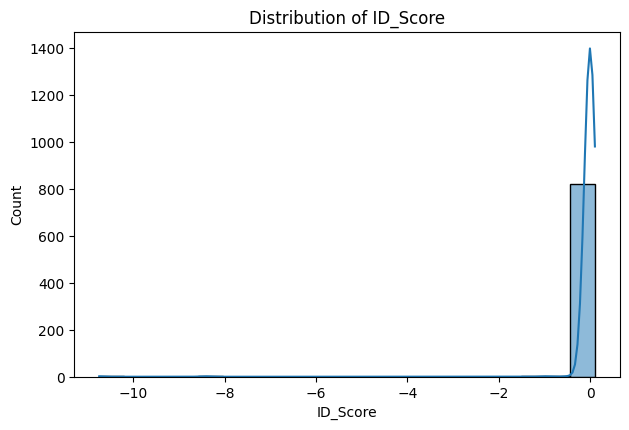

In [587]:
# Check NaN counts
print("NaN counts:")
print(id_score_df[['ID_Score']].isna().sum())

# Plot distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(['ID_Score']):
    plt.subplot(2, 2, i+1)
    sns.histplot(id_score_df[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [588]:
id_score_df_sorted = id_score_df.sort_values(by="ID_Score", ascending=True)
id_score_df_sorted.iloc[:20]

,Stock Code,ID_Score
671,RRP,-10.748887
229,ELITECON,-8.434829
464,KOTIC,-0.994637
542,NACLIND,-0.475175
264,FORCEMOT,-0.227828
505,MANGCHEFER,-0.200454
753,SUVEN,-0.180675
704,SHARDACROP,-0.162282
495,LUMAXTECH,-0.150489
494,LUMAXIND,-0.119993


In [ ]:
id_score_df["ID_Score_z"] = zscore(id_score_df["ID_Score"].fillna(id_score_df["ID_Score"].mean()))

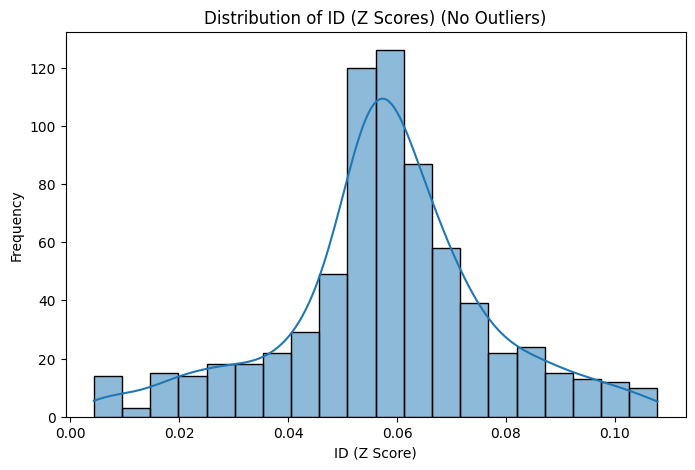

In [637]:
# Remove outliers from ROE_Growth_Avg using IQR
col = "ID_Score_z"
Q1 = id_score_df[col].quantile(0.25)
Q3 = id_score_df[col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_no_outliers = id_score_df[(id_score_df[col] >= lower) & (id_score_df[col] <= upper)]

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_no_outliers[col], bins=20, kde=True)
plt.title("Distribution of ID (Z Scores) (No Outliers)")
plt.xlabel("ID (Z Score)")
plt.ylabel("Frequency")
plt.show()

### Create the Composite Quality Factor

We use ROE, ROE Growth and EBITDA/EV amd calculate Z scores for all of these. The composite wuality score is the average of the three z-scores

In [590]:
df['EBITDA/EV'] = 1/df['EV Per EBITDA Annual']

In [591]:
quality_columns = [
                    'ROE Annual %',
                    'EBITDA/EV',
                    'RoA Annual %',
                    'Cash Flow Return on Assets Annual', 
                             
]

In [592]:
# Create z-score columns for each quality column
for col in quality_columns:
    z_col = f"{col}_Z"
    df[z_col] = zscore(df[col].fillna(df[col].mean()))

# Create a column which is the mean of the z-scores
zscore_cols = [f"{col}_Z" for col in quality_columns]
df['Quality_Z_Mean'] = df[zscore_cols].mean(axis=1)

C:\Users\rajme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [593]:
df_qual = df[["NSE Code", "Quality_Z_Mean"]].sort_values(by="Quality_Z_Mean", ascending=False)
df_qual.iloc[:20]

,NSE Code,Quality_Z_Mean
648,RAYMOND,5.765742
71,ASTERDM,4.521098
679,SANOFICONR,4.459898
267,GMRP&UI,4.004981
726,STAR,3.728120
179,COLPAL,3.430243
791,TIPSMUSIC,3.062054
621,PGHH,2.761041
342,HINDZINC,2.620085
592,PAGEIND,2.257325


In [594]:
margin_columns = [
    'Operating Profit Margin Annual %',
    'Net Profit Margin Annual %'
]

In [595]:
for col in margin_columns:
    z_col = f"{col}_Z"
    df[z_col] = zscore(df[col].fillna(df[col].mean()))

# Create a column which is the mean of the margin z-scores
margin_zscore_cols = [f"{col}_Z" for col in margin_columns]
df['Margin_Z_Mean'] = df[margin_zscore_cols].mean(axis=1)

In [596]:
df_margin = df[["NSE Code", "Margin_Z_Mean"]].sort_values(by="Margin_Z_Mean", ascending=False)
df_margin.iloc[:20]

,NSE Code,Margin_Z_Mean
96,BAJAJHLDNG,7.756554
648,RAYMOND,3.176560
735,SUNDARMHLD,2.923063
612,PGINVIT,1.998267
501,MAHSCOOTER,1.820743
768,TATAINVEST,1.623505
80,AIIL,1.550752
416,JSWHL,1.491876
429,JIOFIN,1.250273
189,NaN,1.237321


#### ROE Growth columns

In [597]:
roe_columns = [
                    'ROE Annual %',
                    'ROE Annual 1Yr Ago %',
                    'ROE Annual 2Yr Ago %', 
                    'ROE Annual 3Yr Ago %',
                    'ROE Annual 4Yr Ago %',
                    'ROE Annual 5Yr Ago %', 
]

In [598]:
roe_growth_cols = []
for i in range(len(roe_columns) - 1):
    col_new = f"ROE_Growth_{i+1}"
    df[col_new] = (df[roe_columns[i]] - df[roe_columns[i+1]]) / df[roe_columns[i+1]].replace(0, np.nan).abs()
    roe_growth_cols.append(col_new)

df[["NSE Code"] + roe_growth_cols].head()

,NSE Code,ROE_Growth_1,ROE_Growth_2,ROE_Growth_3,ROE_Growth_4,ROE_Growth_5
0,360ONE,-0.383526,0.106312,0.093409,0.476628,0.941964
1,3MINDIA,0.139699,0.058989,0.998129,0.590774,-0.363033
2,63MOONS,-1.146084,13.769231,0.695906,0.173913,-0.417808
3,ABB,0.266156,0.015557,0.602025,1.115321,-0.295006
4,ACC,-0.095105,1.284345,-0.518832,0.155417,-0.056161


In [599]:
df['ROE_Growth_Avg'] = df[roe_growth_cols].mean(axis=1)

# Create a Z-score column for the average ROE growth
df['ROE_Growth_Z'] = zscore(df['ROE_Growth_Avg'].fillna(df['ROE_Growth_Avg'].mean()))

In [600]:
df_roe = df[["NSE Code", "ROE_Growth_Z"]].sort_values(by="ROE_Growth_Z", ascending=False)
df_roe.iloc[:20]

,NSE Code,ROE_Growth_Z
792,TITAGARH,5.386971
490,LLOYDSME,3.992951
208,DBL,2.620309
5,ACMESOLAR,2.164121
387,INDUSINVIT,1.947668
429,JIOFIN,1.678786
263,GVT&D,1.358005
134,BORORENEW,1.333151
618,PRSMJOHNSN,1.065800
489,NaN,0.666022


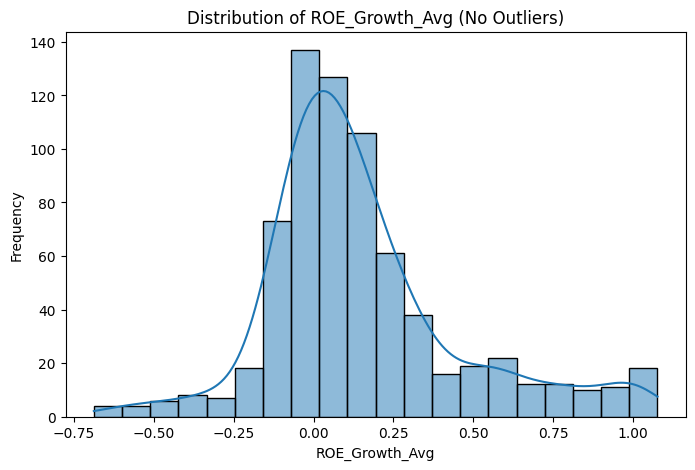

In [601]:
# Remove outliers from ROE_Growth_Avg using IQR
col = "ROE_Growth_Avg"
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_no_outliers = df[(df[col] >= lower) & (df[col] <= upper)]

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_no_outliers[col], bins=20, kde=True)
plt.title("Distribution of ROE_Growth_Avg (No Outliers)")
plt.xlabel("ROE_Growth_Avg")
plt.ylabel("Frequency")
plt.show()

In [602]:
df['Composite_Quality'] = df[['Quality_Z_Mean', 'Margin_Z_Mean', 'ROE_Growth_Z']].mean(axis=1)
df['Composite_Quality_Z'] = zscore(df['Composite_Quality'].fillna(df['Composite_Quality'].mean()))

In [603]:
df_composite_quality = df[["NSE Code", "Composite_Quality_Z"]].sort_values(by="Composite_Quality_Z", ascending=False)
df_composite_quality.iloc[:20]

,NSE Code,Composite_Quality_Z
648,RAYMOND,4.931015
96,BAJAJHLDNG,4.062680
71,ASTERDM,3.407014
726,STAR,2.672735
792,TITAGARH,2.671842
679,SANOFICONR,2.644553
490,LLOYDSME,2.573078
267,GMRP&UI,2.297169
791,TIPSMUSIC,2.162437
179,COLPAL,2.014672


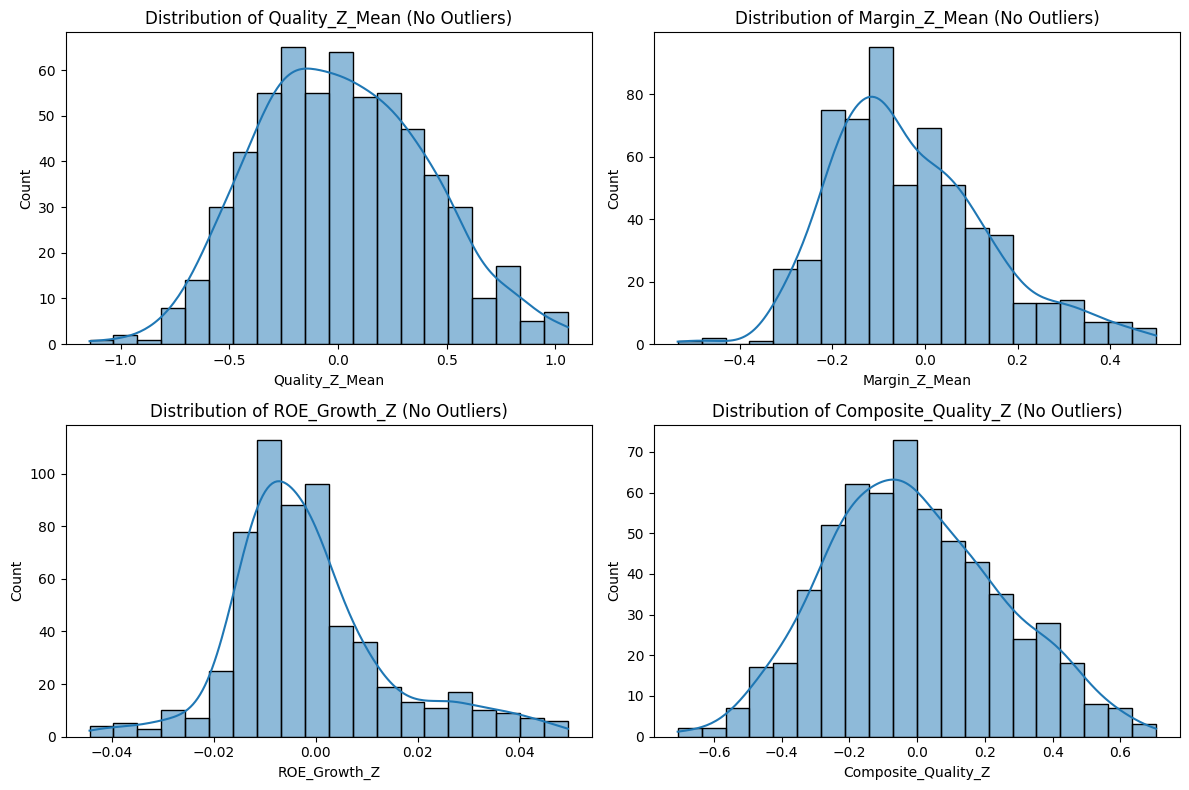

In [604]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers using the IQR method for each z-score column
zscore_cols = ['Quality_Z_Mean', 'Margin_Z_Mean', 'ROE_Growth_Z', 'Composite_Quality_Z']
df_no_outliers = df.copy()
for col in zscore_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)]

# Plot distributions of Z scores without outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(zscore_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_no_outliers[col], bins=20, kde=True)
    plt.title(f'Distribution of {col} (No Outliers)')
plt.tight_layout()
plt.show()

## Create Composite Factor Score
Now we combine th momentum ID Score with the composite quality score to create a composite factor score

In [605]:
df_merged = pd.merge(df[['Stock Code', 'Composite_Quality_Z']], id_score_df[['Stock Code', 'ID_Score_z']], left_on='Stock Code', right_on='Stock Code', how='left')
df_merged.head()

,Stock Code,Composite_Quality_Z,ID_Score_z
0,360ONE,-0.037365,0.056319
1,3MINDIA,0.279116,0.069145
2,63MOONS,-1.273200,0.060400
3,ABB,0.291675,0.056722
4,ACC,-0.043808,0.059897


In [606]:
df_merged[df_merged['Stock Code'].isna()]

,Stock Code,Composite_Quality_Z,ID_Score_z


In [607]:
df_merged['Composite Factor Score'] = (df_merged['Composite_Quality_Z'] - df_merged['ID_Score_z'])/2
df_merged = df_merged.sort_values(by='Composite Factor Score', ascending=False).reset_index(drop=True)
df_merged[:20]

,Stock Code,Composite_Quality_Z,ID_Score_z,Composite Factor Score
0,RRP,-0.061879,-22.968579,11.453350
1,ELITECON,0.236328,-18.012024,9.124176
2,RAYMOND,4.931015,0.141008,2.395004
3,BAJAJHLDNG,4.062680,0.054801,2.003940
4,ASTERDM,3.407014,0.067969,1.669523
5,STAR,2.672735,-0.016272,1.344503
6,TITAGARH,2.671842,0.076680,1.297581
7,SANOFICONR,2.644553,0.056189,1.294182
8,LLOYDSME,2.573078,0.049700,1.261689
9,GMRP&UI,2.297169,0.058198,1.119485


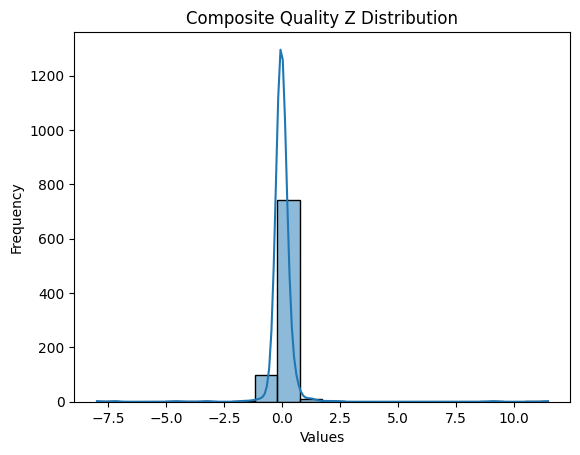

In [608]:
sns.histplot(df_merged['Composite Factor Score'], bins=20, kde=True)
plt.title('Composite Quality Z Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### Red Flags - Remove bad stocks

#### STA and SNOA to measure balance sheet bloat

CFO (cash flow from operations), as a measure of performance, is less subject to distortion than is the net income figure. This is so because the accrual system, which produces the income number, relies on accruals, deferrals, allocations and valuations, all of which involve higher degrees of subjectivity than what enters the determination of CFO. That is why analysts prefer to relate CFO to reported net income as a check on the quality of that income. Some analysts believe that the higher the ratio of CFO to net income, the higher the quality of that income. Put another way, a company with a high level of net income and a low cash flow may be using income recognition or expense accrual criteria that are suspect.
- STA = (net income – cash flow from operations) / Total Assets (see Sloan 1996)
- SNOA = (Operating Assets – Operating Liabilities) / Total Assets (see Hirshleifer et al. 2004)

In [609]:
df['STA'] = (df['Net Profit Annual'] - df['Cash from Operating Activity Annual'])/df['Total Assets Annual']
df['SNOA'] = (df['Total Current Assets Annual'] - df['Total Current Liabilities Annual'])/df['Total Assets Annual']

In [610]:
# Set negative values in STA and SNOA columns to 0
df['STA'] = df['STA'].apply(lambda x: max(x, 0) if pd.notnull(x) else x)
df['SNOA'] = df['SNOA'].apply(lambda x: max(x, 0) if pd.notnull(x) else x)

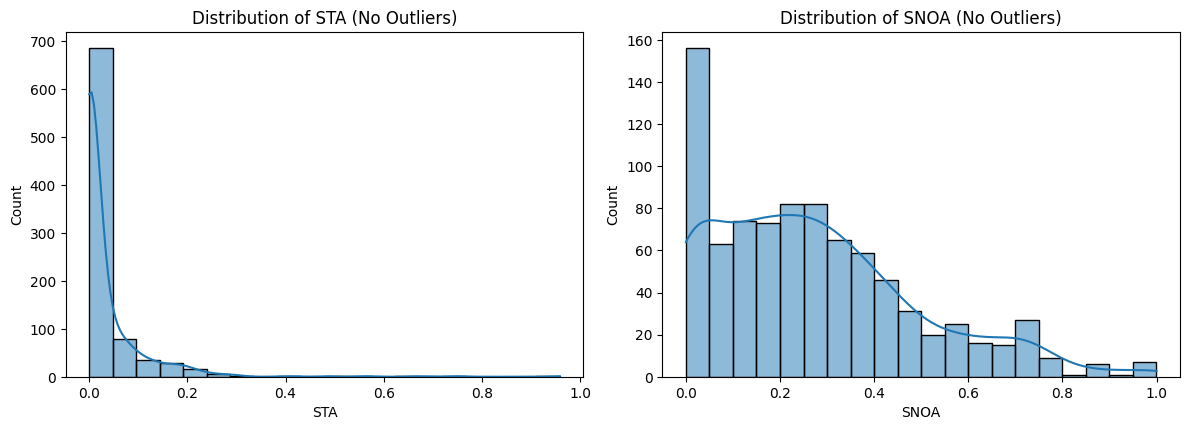

In [611]:
accounting_bloat_cols = ['STA', 'SNOA']

plt.figure(figsize=(12, 8))
for i, col in enumerate(accounting_bloat_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Distribution of {col} (No Outliers)')
plt.tight_layout()
plt.show()

In [612]:
df['STA_Z'] = zscore(df['STA'].fillna(df['STA'].mean()))
df['SNOA_Z'] = zscore(df['SNOA'].fillna(df['SNOA'].mean()))

In [613]:
df['AccountingBloat_Z'] = df[['STA_Z', 'SNOA_Z']].mean(axis=1)

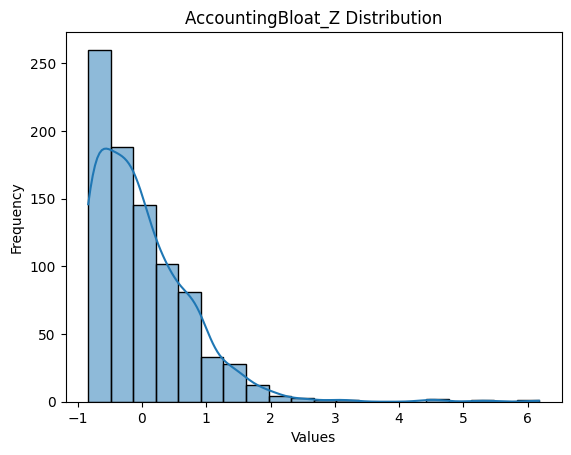

In [614]:
sns.histplot(df['AccountingBloat_Z'], bins=20, kde=True)
plt.title('AccountingBloat_Z Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [615]:
df_sta = df[["Stock Code", "AccountingBloat_Z"]].sort_values(by="AccountingBloat_Z", ascending=False)
df_sta.iloc[:20]

,Stock Code,AccountingBloat_Z
648,RAYMOND,6.177040
633,RRP,5.316626
470,KOTIC,4.537985
71,ASTERDM,4.494875
347,HUDCO,3.183558
80,AIIL,3.014846
579,OSWALPUMPS,2.579041
726,STAR,2.548732
719,LOTUSDEV,2.325244
96,BAJAJHLDNG,2.187943


#### Large Other Income in P&L

In [616]:
df['Percent Extraordinary of Profit'] = (df['Extraordinary Items Annual']) / df['Profit Before Tax Annual'] 
df['Percent Extraordinary of Profit']

0      0.000000
1      0.000000
2     -0.140173
3      0.000000
4      0.000000
         ...   
857   -0.000000
858    0.000000
859    0.000000
860    0.000000
861    0.000000
Name: Percent Extraordinary of Profit, Length: 862, dtype: float64

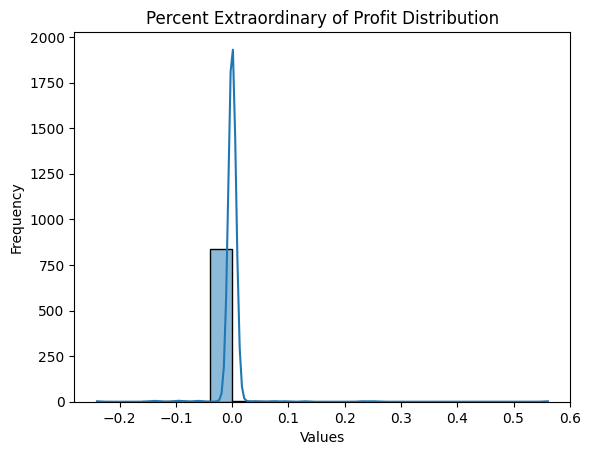

In [617]:
sns.histplot(df['Percent Extraordinary of Profit'], bins=20, kde=True)
plt.title('Percent Extraordinary of Profit Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [618]:
df['ExtraordinaryIncome_Z'] = zscore(df['Percent Extraordinary of Profit'].fillna(df['Percent Extraordinary of Profit'].mean()))

In [619]:
df_extra_income = df[["NSE Code", "ExtraordinaryIncome_Z"]].sort_values(by="ExtraordinaryIncome_Z", ascending=False)
df_extra_income.iloc[:20]

,NSE Code,ExtraordinaryIncome_Z
641,RKFORGE,21.342357
352,ICICIPRULI,9.527160
680,SANOFI,8.788779
763,TATACHEM,4.855957
775,TECHNOE,3.531033
395,INOXGREEN,2.797055
319,HDFCLIFE,1.557147
21,ADANIENSOL,0.894203
277,GENUSPOWER,0.467612
573,ONESOURCE,0.370833


### High Debt to Equity

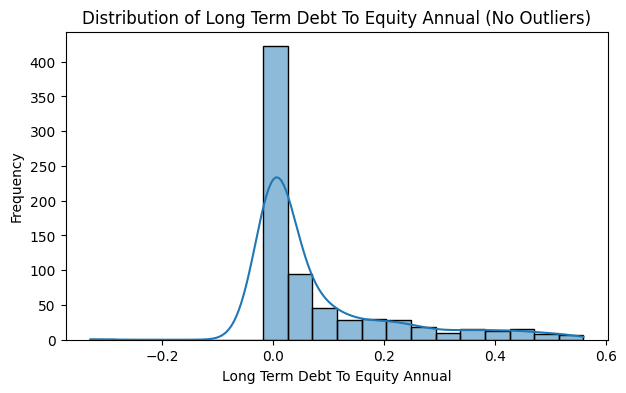

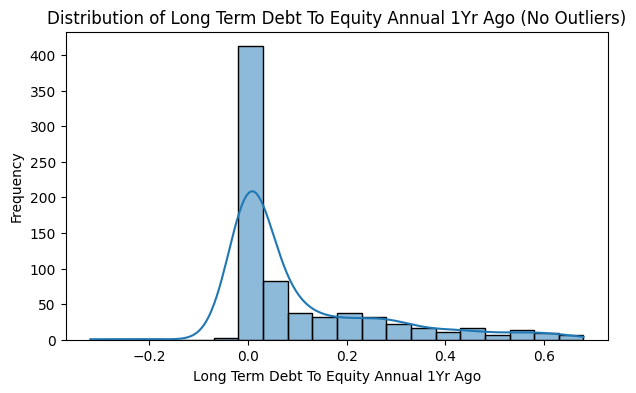

In [638]:
debt_equity_cols = ['Long Term Debt To Equity Annual',
       'Long Term Debt To Equity Annual 1Yr Ago']


# Remove outliers and plot for each debt to equity column
for col in ['Long Term Debt To Equity Annual', 'Long Term Debt To Equity Annual 1Yr Ago']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[col] >= lower) & (df[col] <= upper)]
    
    plt.figure(figsize=(7, 4))
    sns.histplot(df_no_outliers[col], bins=20, kde=True)
    plt.title(f'Distribution of {col} (No Outliers)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [621]:
df['Debt_Equity_Mean'] = df[debt_equity_cols].mean(axis=1)

max_de = df['Debt_Equity_Mean'].max()
df['Debt_Equity_Mean'] = df['Debt_Equity_Mean'].apply(lambda x: max_de if pd.notnull(x) and x < 0 else x)

# Create a z-score column for the mean debt to equity
df['Debt_Equity_Mean_Z'] = zscore(df['Debt_Equity_Mean'].fillna(df['Debt_Equity_Mean'].mean()))

In [640]:
df_debt_equity = df[["Stock Code", "Debt_Equity_Mean_Z"]].sort_values(by="Debt_Equity_Mean_Z", ascending=False)
df_debt_equity.iloc[:10]

,Stock Code,Debt_Equity_Mean_Z
749,SWIGGY,6.096739
773,TTML,6.096739
49,ALOKINDS,6.096739
686,THELEELA,6.096739
701,RENUKA,6.096739
718,SPICEJET,6.096739
732,SPARC,6.096739
633,RRP,6.096739
85,AWFIS,6.096739
836,IDEA,6.096739


#### High P/E: To avoid extreme valuations

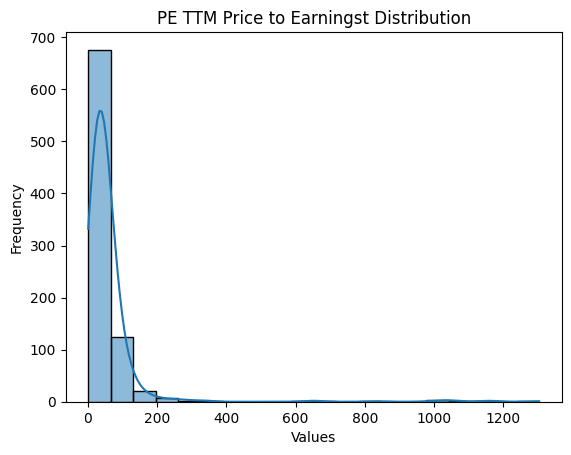

In [623]:
df['PE TTM Price to Earnings']

sns.histplot(df['PE TTM Price to Earnings'], bins=20, kde=True)
plt.title('PE TTM Price to Earningst Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [624]:
mean_pe = df['PE TTM Price to Earnings'].mean()
df['PE TTM Price to Earnings'] = df['PE TTM Price to Earnings'].apply(lambda x: mean_pe if pd.notnull(x) and x < 0 else x)

df['PE_Z'] = zscore(df['PE TTM Price to Earnings'].fillna(df['PE TTM Price to Earnings'].mean()))

In [642]:
df_pe = df[["Stock Code", "PE_Z"]].sort_values(by="PE_Z", ascending=False)
df_pe.iloc[:10]

,Stock Code,PE_Z
231,EMBDL,11.315634
682,SAPPHIRE,10.098412
846,WESTLIFE,9.920916
257,FISCHER,9.108193
244,ETERNAL,8.883189
228,ELITECON,8.879556
633,RRP,8.500400
250,NYKAA,7.084063
782,FACT,5.412109
161,CENTUM,5.356153


### Create a composite Z-score for Red Flags

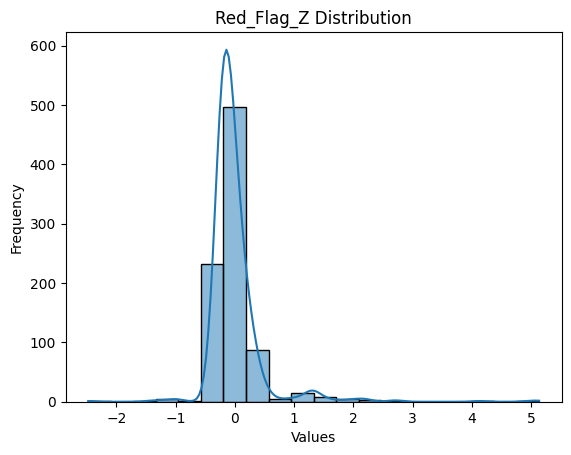

In [626]:
red_flag_z_cols = ['AccountingBloat_Z', 'ExtraordinaryIncome_Z', 'Debt_Equity_Mean_Z', 'PE_Z']

df['Red_Flag_Z'] = df[red_flag_z_cols].mean(axis=1)

sns.histplot(df['Red_Flag_Z'], bins=20, kde=True)
plt.title('Red_Flag_Z Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### Create a final score with Composite Momentum, Quality and Risk Factors

In [627]:
df_merged_with_red_flags = pd.merge(df_merged[['Stock Code', 'Composite Factor Score']], df[['Stock Code', 'Red_Flag_Z']], \
                                    left_on='Stock Code', right_on='Stock Code', how='left')
df_merged_with_red_flags.head()

,Stock Code,Composite Factor Score,Red_Flag_Z
0,RRP,11.453350,4.973207
1,ELITECON,9.124176,4.130454
2,RAYMOND,2.395004,1.380984
3,BAJAJHLDNG,2.003940,0.364241
4,ASTERDM,1.669523,1.149626


In [643]:
df_merged_with_red_flags['Final Factor Score'] = df_merged_with_red_flags['Composite Factor Score'] - df_merged_with_red_flags['Red_Flag_Z']
df_merged_with_red_flags = df_merged_with_red_flags.sort_values(by='Final Factor Score', ascending=False).reset_index(drop=True)
df_merged_with_red_flags[:20]

,Stock Code,Composite Factor Score,Red_Flag_Z,Final Factor Score,Red Flag
0,RRP,11.453350,4.973207,6.480143,1
1,ELITECON,9.124176,4.130454,4.993722,1
2,ABFRL,-0.351955,-2.473532,2.121578,0
3,BAJAJHLDNG,2.003940,0.364241,1.639698,0
4,LLOYDSME,1.261689,-0.216602,1.478291,0
5,GMRP&UI,1.119485,-0.186757,1.306243,0
6,TITAGARH,1.297581,0.006563,1.291019,0
7,SANOFICONR,1.294182,0.049537,1.244645,0
8,NAZARA,-0.174640,-1.411757,1.237117,0
9,COLPAL,0.986926,-0.209654,1.196580,0


In [629]:
# Mark stocks in the top 5 percentile of Red_Flag_Z
threshold = df_merged_with_red_flags['Red_Flag_Z'].quantile(0.95)
df_merged_with_red_flags['Red Flag'] = (df_merged_with_red_flags['Red_Flag_Z'] >= threshold).astype(int)

df_merged_with_red_flags[df_merged_with_red_flags['Red Flag'] == 0].iloc[:20]

,Stock Code,Composite Factor Score,Red_Flag_Z,Final Factor Score,Red Flag
2,ABFRL,-0.351955,-2.473532,2.121578,0
3,BAJAJHLDNG,2.003940,0.364241,1.639698,0
4,LLOYDSME,1.261689,-0.216602,1.478291,0
5,GMRP&UI,1.119485,-0.186757,1.306243,0
6,TITAGARH,1.297581,0.006563,1.291019,0
7,SANOFICONR,1.294182,0.049537,1.244645,0
8,NAZARA,-0.174640,-1.411757,1.237117,0
9,COLPAL,0.986926,-0.209654,1.196580,0
10,HINDZINC,0.837225,-0.312780,1.150006,0
11,KAJARIACER,-0.048304,-1.065237,1.016933,0
